In [1]:
import paragami
import vittles
import autograd
from autograd import numpy as np
from autograd import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from copy import deepcopy
import time
import scipy as osp

import microcredit_mixture_rgiordandev
from microcredit_mixture_rgiordandev import microcredit_vb_lib as mm_lib

In [5]:
base_draws = 30
use_smuber = False
out_filename = 'output/microcredit_project_advi_{}draws_smuber{}.npz'.format(base_draws, use_smuber)

#out_filename = 'output/microcredit_project_advi_{}draws.npz'.format(5)
advi_dict = np.load(out_filename)

advi_param_pattern = paragami.get_pattern_from_json(str(advi_dict['advi_param_pattern_json']))
param_pattern = paragami.get_pattern_from_json(str(advi_dict['param_pattern_json']))
advi_param_pattern = paragami.get_pattern_from_json(str(advi_dict['advi_param_pattern_json']))
param_pattern = paragami.get_pattern_from_json(str(advi_dict['param_pattern_json']))
hess0 = advi_dict['hess0']
advi_params_free = advi_dict['advi_params_free']
advi_params = advi_param_pattern.fold(advi_params_free, free=True)
mean_params = param_pattern.fold(advi_dict['params_free'], free=True)
base_draws = advi_dict['base_draws']
prior_pattern = paragami.get_pattern_from_json(str(advi_dict['prior_param_pattern_json']))
prior_params = prior_pattern.fold(advi_dict['prior_params_flat'], free=False)

BadZipFile: Bad magic number for file header

In [3]:
raw_data = pd.read_csv('../R/data/microcredit_project_data_cleaned.csv') 
print(raw_data)
data = dict()

data['site'] = raw_data["site"].to_numpy().astype('int')
data['profit'] = raw_data["profit"].to_numpy()
data['treatment'] = raw_data["treatment"].to_numpy().astype('int')
data['cat'] = raw_data["cat"].to_numpy().astype('int')
data['weights'] = None

num_obs = len(data['profit'])
print(num_obs)

data['use_smuber'] = use_smuber

       site      profit  treatment  cat
0         1    0.000000          0    2
1         1  513.246492          1    3
2         1    0.000000          1    2
3         1    0.000000          0    2
4         1    0.000000          0    2
...     ...         ...        ...  ...
35298     7  -10.637987          0    1
35299     7   87.503514          0    3
35300     7   -5.736498          0    1
35301     7    0.000000          0    2
35302     7   28.722566          0    3

[35303 rows x 4 columns]
35303


In [4]:
get_log_loss_free = paragami.FlattenFunctionInput(
    lambda advi_params: mm_lib.get_advi_loss(
        advi_params, base_draws, data, prior_params, param_pattern),
    patterns=advi_param_pattern,
    free=True)
objective = paragami.OptimizationObjective(get_log_loss_free)
grad0 = objective.grad(advi_params_free)
print(np.linalg.norm(grad0))
print(np.linalg.norm(np.linalg.solve(hess0, grad0)))

2.773361238178103e-06
2.1844107234763186e-06


In [5]:
def get_weighted_log_loss(advi_params, weights):
    return mm_lib.get_advi_loss(
        advi_params, base_draws, data, prior_params, param_pattern, weights)

get_weighted_log_loss_free = paragami.FlattenFunctionInput(
    get_weighted_log_loss,
    patterns=advi_param_pattern,
    free=True)

estimating_equation = autograd.grad(get_weighted_log_loss, argnum=0)
w1 = np.ones(num_obs)

# Sanity checks
assert \
    get_weighted_log_loss_free(advi_params_free, w1) - \
        get_log_loss_free(advi_params_free) == 0

assert \
    get_weighted_log_loss_free(advi_params_free, None) - \
        get_log_loss_free(advi_params_free) == 0

In [6]:
# Make sure this is feasible.
w_grad = autograd.grad(get_weighted_log_loss_free, argnum=1)(advi_params_free, w1)
print(w_grad.shape)

(35303,)


In [7]:
get_theta_grad = autograd.grad(get_weighted_log_loss_free, argnum=0)
get_cross_hess = autograd.jacobian(get_theta_grad, argnum=1)

cross_hess_time = time.time()
cross_hess_at_opt = get_cross_hess(advi_params_free, w1)
cross_hess_time = time.time() - cross_hess_time

In [8]:
print(cross_hess_time)
print(cross_hess_at_opt.shape)

57.23569583892822
(248, 35303)


In [9]:
hess_solver = vittles.solver_lib.get_dense_cholesky_solver(hess0)
#hess_solver(grad0)

In [10]:
weight_sens_approx = \
    vittles.sensitivity_lib.HyperparameterSensitivityLinearApproximation(
        objective_fun=get_weighted_log_loss_free,
        opt_par_value=advi_params_free,
        hyper_par_value=w1,
        validate_optimum=False,
        hessian_at_opt=hess0,
        cross_hess_at_opt=cross_hess_at_opt)

In [11]:
influence_mat = weight_sens_approx.get_dopt_dhyper()

In [12]:
influence_mat.shape

(248, 35303)

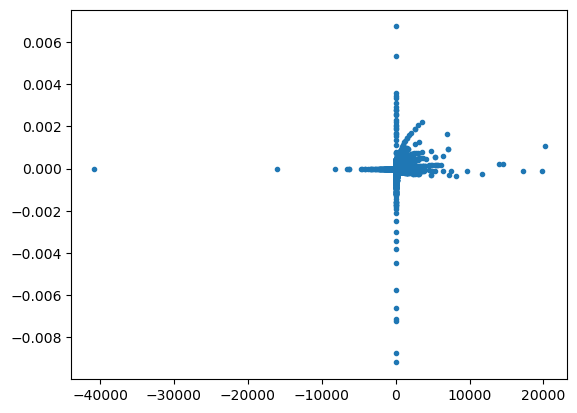

In [13]:
plt.plot(data['profit'], influence_mat[1, :], '.')

In [14]:
#get_advi_mean(advi_params, base_draws, param_pattern)
get_advi_mean_free = paragami.FlattenFunctionInput(
    mm_lib.get_advi_mean, advi_param_pattern, free=True, argnums=[0])
advi_mean_free_jacobian = autograd.jacobian(
    get_advi_mean_free, argnum=0)(advi_params_free, base_draws, param_pattern)
mean_influence_mat = advi_mean_free_jacobian @ influence_mat

In [15]:
lr_cov = advi_mean_free_jacobian @ hess_solver(advi_mean_free_jacobian.T)

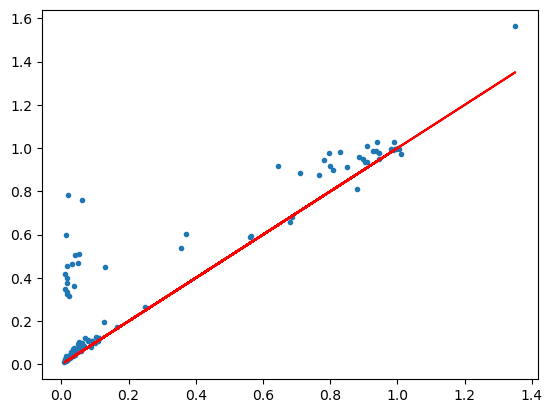

In [16]:
def get_advi_sd(advi_params, base_draws, param_pattern):
    flat_draws = mm_lib.get_flat_draws(advi_params, base_draws, param_pattern)
    return np.std(flat_draws, axis=0)

advi_sd = get_advi_sd(advi_params, base_draws, param_pattern)
lrvb_sd = np.sqrt(np.diag(lr_cov))
plt.plot(advi_sd, lrvb_sd, '.')
plt.plot(advi_sd, advi_sd, 'r')


In [17]:
advi_mean_free_jacobian.shape

(124, 248)

# Prior sensitivity

In [18]:
def get_prior_log_loss(advi_params, prior_params):
    return mm_lib.get_advi_loss(
        advi_params, base_draws, data, prior_params, param_pattern, weights=None)

get_prior_log_loss_free = paragami.FlattenFunctionInput(
    get_prior_log_loss,
    patterns=[ advi_param_pattern, prior_pattern ],
    free=[True, True],
    argnums=[0, 1])

estimating_equation = autograd.grad(get_prior_log_loss_free, argnum=0)
prior_params_free = prior_pattern.flatten(prior_params, free=True)

# Sanity check
assert \
    get_prior_log_loss_free(advi_params_free, prior_params_free) - \
        get_log_loss_free(advi_params_free) == 0

In [19]:
prior_sens_approx = \
    vittles.sensitivity_lib.HyperparameterSensitivityLinearApproximation(
        objective_fun=get_prior_log_loss_free,
        opt_par_value=advi_params_free,
        hyper_par_value=prior_params_free,
        validate_optimum=False,
        hessian_at_opt=hess0)

In [20]:
prior_influence_mat = prior_sens_approx.get_dopt_dhyper()

# Save

In [21]:
save_dict = {}
save_dict['out_filename'] = out_filename
save_dict['cross_hess_time'] = cross_hess_time
save_dict['cross_hess_at_opt'] = cross_hess_at_opt
save_dict['advi_mean_free_jacobian'] = advi_mean_free_jacobian
save_dict['influence_mat'] = influence_mat
save_dict['lr_cov'] = lr_cov
save_dict['mean_influence_mat'] = mean_influence_mat
save_dict['use_smuber'] = data['use_smuber']
save_dict['prior_influence_mat'] = prior_influence_mat


In [22]:
sens_filename = 'output/microcredit_project_weight_sensitivity_{}draws_smuber{}.npz'.format(
    base_draws.shape[1], data['use_smuber'])
print('Saving to {}'.format(sens_filename))

np.savez_compressed(**save_dict, file=sens_filename)

Saving to output/microcredit_project_weight_sensitivity_30draws_smuberFalse.npz
